<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analisys
* iterator

In [6]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta
import matplotlib.pyplot as plt 
import os
import re 

from functools import reduce
from collections import defaultdict, Counter, ChainMap

# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'online_retail_II.xlsx',
 'scanner_data.csv',
 'test.csv',
 'sample_data']

In [3]:
df = pd.read_csv('scanner_data.csv')
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [4]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.columns = [a.lower() if a!= 'Customer_ID' else 'id' for a in df.columns] 
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.sales_amount
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount,week,month,rev
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-02-01,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-02-01,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-02-01,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-02-01,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,6.88


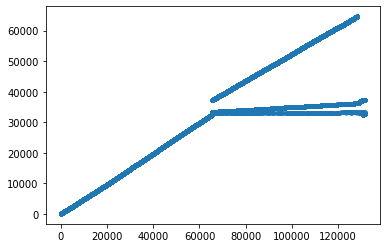

In [9]:
plt.plot(range(len(df)), df['transaction_id'], '.')

In [17]:
cnt_trans = df['transaction_id'].value_counts().reset_index().sort_values(['transaction_id'], ascending = 0)
cnt_trans = cnt_trans[cnt_trans['transaction_id'] >= 2].reset_index()
cnt_trans.head()

,level_0,index,transaction_id
0,0,1348,21
1,1,19098,21
2,2,42295,20
3,3,39032,19
4,4,28731,19


In [20]:
df[df['id'] == 17061	]

,date,id,transaction_id,sku_category,sku,quantity,sales_amount,week,month,rev
24418,2016-12-03,17061,11812,2K4,YS9IS,1.0,7.85,2016-11-28,2016-12-01,7.85
25350,2016-03-15,17061,12292,IEV,0QK7Q,1.0,5.40,2016-03-14,2016-03-01,5.40
28384,2016-03-22,17061,13774,QCG,V8L6W,1.0,3.82,2016-03-21,2016-03-01,3.82
28385,2016-03-22,17061,13774,N5F,7IE9S,1.0,8.38,2016-03-21,2016-03-01,8.38
28386,2016-03-22,17061,13774,N5F,6Y6GP,2.0,8.50,2016-03-21,2016-03-01,17.00
...,...,...,...,...,...,...,...,...,...,...
129954,2016-07-30,17061,36932,69K,C7BXU,1.0,6.07,2016-07-25,2016-07-01,6.07
129955,2016-07-30,17061,36932,N5F,6Y6GP,1.0,4.26,2016-07-25,2016-07-01,4.26
130452,2016-01-08,17061,37135,XG4,TFBST,2.0,13.50,2016-01-04,2016-01-01,27.00
130453,2016-01-08,17061,37135,LPF,3103X,2.0,14.16,2016-01-04,2016-01-01,28.32


In [26]:
cnt_sales = df.groupby(['sku_category', 'month']).agg({'rev' : 'sum', 'id' : 'count'}).reset_index().rename(columns = {'id':'cnt'})
cnt_sales = pd.melt(cnt_sales, id_vars = ['sku_category', 'month'], var_name = 'type')
cnt_sales['ratio'] = cnt_sales.groupby(['month','type'])['value'].apply(lambda x : round(x/x.max()*100,2))
cnt_sales.head()

,sku_category,month,type,value,ratio
0,01F,2016-01-01,rev,5606.44,31.55
1,01F,2016-02-01,rev,4870.99,30.54
2,01F,2016-03-01,rev,6514.69,35.97
3,01F,2016-04-01,rev,6938.15,36.91
4,01F,2016-05-01,rev,7772.92,33.41


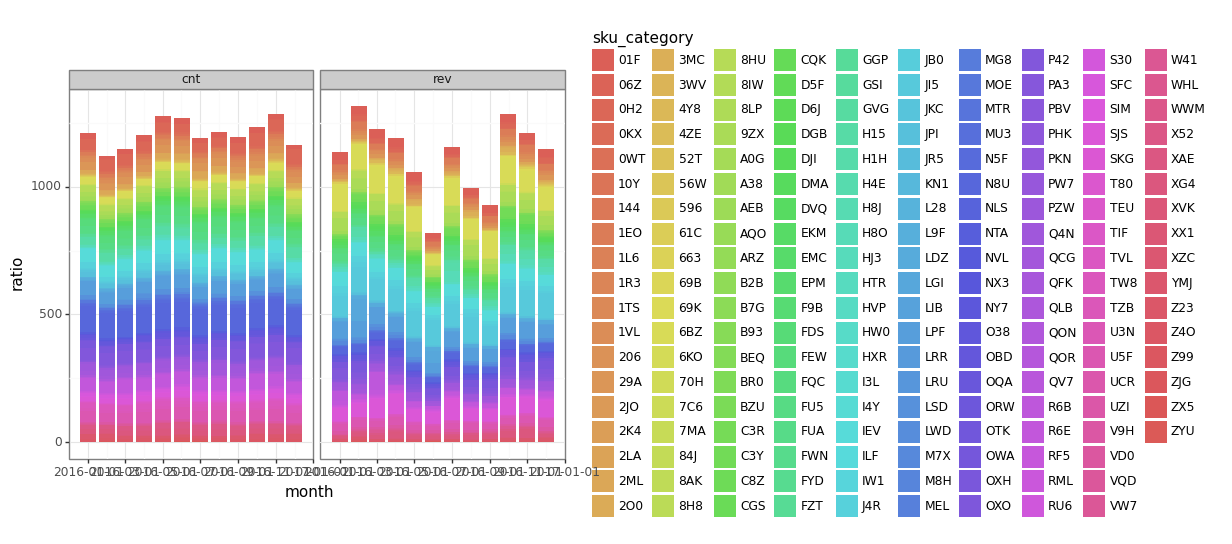

<ggplot: (8748898007769)>

In [28]:
(
    ggplot(cnt_sales, aes('month', 'ratio', fill = 'sku_category')) +
    gg.geom_col() +
    gg.facet_wrap('~type') +
    gg.theme_bw()
)

# iterator

In [30]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = {letter : [r, c] for r, rows in enumerate(mat) for c, letter in enumerate(rows)}
a

{'A': [0, 0],
 'B': [0, 1],
 'C': [0, 2],
 'D': [1, 0],
 'E': [1, 1],
 'F': [1, 2],
 'G': [2, 0],
 'H': [2, 1],
 'I': [2, 2]}

In [31]:
arr = np.empty([3,3], dtype = 'object')
for k, v in a.items() :
  arr[v[0], v[1]] = k
arr

array([['A', 'B', 'C'],
       ['D', 'E', 'F'],
       ['G', 'H', 'I']], dtype=object)